# Random Forest Notebook

## Description:

This notebook aims to implement a **Random Forests** for Forecasting Time Series.

As explained in the **SeriesAnalysis** notebook, this notebook may use the results already obtained in **Series Analysis**, so that the focus can be only on the Model itself. The results that will be used are the stationary series obtained from the original series, in order to verify if the **Random Forests** are capable of forecasting both stationary and non stationary series.

## Notebook Details:

This notebook is divided into 2 main parts: Stationary Series (were differentiated) and Non-stationary Series (original series)

The purpose of crating those parts is to compare with the ARIMA results, that need the series to be stationary.

Each of the parts is divided into subparts as follows:
 - Importing data
 - Splitting Data into a Moving Window approach and into train and test sets
 - Hyperparamter search
 - Training Models with the best hyperparameters
 - Comparing the fitted models with the original series
 - Testing and comparing the models with 1 step forecast
 - Testing and comparing the models with 12 step forecast

In [1]:
#Packages needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.ensemble    # For RandomForestClassifier class
import sklearn.model_selection # hyperparameter search
# COMPLETE WITH PACKEGES FOR MLP

### Some useful functions -> COMPLETE WITH MORE IF NEEDED AND DELETE ONES NOT NEEDED

In [2]:
#Read and filter data from csv files, as well as handle missing values
def read_filter(path,index,value):
    df = pd.read_csv(path)
    series = df.loc[:,[index,value]]
    series.set_index(index,inplace=True)
    series.index=pd.to_datetime(series.index)
    series = series.asfreq('d')
    series = series.interpolate()
    return series

# #Ploting a single time series
# def plot_series(serie,title,xlabel,ylabel):
#     fig = plt.figure()
#     plt.plot(serie)
#     fig.suptitle(title, fontsize=20)
#     plt.xlabel(xlabel, fontsize=18)
#     plt.ylabel(ylabel, fontsize=18)
#     plt.show()

#plot two time series
def plot_2_series(real,model,title,xlabel="Time",ylabel="Values"):
    fig = plt.figure()
    plt.plot(real)
    plt.plot(model)
    fig.suptitle(title, fontsize=20)
    # plt.xlabel(xlabel, fontsize=18)
    # plt.ylabel(ylabel, fontsize=18)
    plt.legend(['Original Series','Predicted'])
    plt.show()
    
    
# differentiate the series
def diff(series,t):
    for i in range(t):
        series = series - series.shift(1)
        series = series.dropna()
    
    return series


#normalize time series values into range [0,1]
def normalize(serie):
    values = serie.values[:,0]

    _min = np.min(values)
    _max = np.max(values)
    
    norm_values = (values - _min)/(_max - _min)
    
    newSerie = pd.Series(norm_values)

    return newSerie

#moving_window -> creates the training and test dataset based on moving window aproach
def moving_window(serie,lags,split):
    
    data_values = serie.values

    train_values = data_values[:-split].reshape(-1,1)
    test_values = data_values[-split:].reshape(-1,1)

    train_data = np.zeros((train_values.shape[0] - (lags + 1), lags + 2))
    test_data = np.zeros((test_values.shape[0], lags + 2))
    
    
    all_data = np.vstack((train_values,test_values))

    new_data = np.zeros((train_values.shape[0] - (lags + 1) + test_values.shape[0],lags + 2))
    
    
    for i in range(lags + 2):
        new_data[:,i] = all_data[i:new_data.shape[0]+i,0]

    train_data = new_data[:-test_values.shape[0],:]
    test_data = new_data[-test_values.shape[0]:,:]

    data_columns = [f'y(t{i})' if i < 0 else 'y(t)' if i == 0 else f'y(t+{i})' for i in range(-lags,2)] 
    new_train_df = pd.DataFrame(train_data, columns=data_columns,dtype=np.float64)
    new_test_df = pd.DataFrame(test_data, columns=data_columns,dtype=np.float64)

    return new_train_df,new_test_df

#function to split both training and test datasets into X and y, data and targets
def train_test(train_data,test_data):
    X_train = train_data.values[:,:-1]
    y_train = train_data.values[:,-1]

    X_test = test_data.values[:,:-1]
    y_test = test_data.values[:,-1]

    return X_train, y_train, X_test, y_test

    
#Compute some error metrics
def errors(actual, predicted):
    mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
    me = np.mean(predicted - actual)             # ME
    mae = np.mean(np.abs(predicted - actual))    # MAE
    mpe = np.mean((predicted - actual)/actual)   # MPE
    rmse = np.mean((predicted - actual)**2)**.5  # RMSE
    
    errors = [['MAPE',mape],['ME',me],['MAE',mae],['MPE',mpe],['RMSE',rmse]]
    
    errors = pd.DataFrame(errors,columns=['Error','Value'])
    return errors

#Funtion that implements h_step forecast
def h_step_forecast(model,lag_values,horizon):
    '''
    model is the clf estimator
    lag_values is a pandas series with the last 12 pass values of the time series
    horizon is a integer witch represent the number of future steps we wish to predict

    How this function works:
        lags values is our x_Train dataset
        we will use the lag values to predict y_t+1
        then we will shift the lag values so that the most recent value is the predicted value y_t+1
        We will repeat this process until the series is full of forecasted values [y_t+1,y_t+2,...,y_t+h]
    '''
    for i in range(horizon):
        y_hat=model.predict(lag_values) # forecasting y_t+1
        for j in range(1,lag_values.shape[1]-2): #shifting every entry to the left 
            for k in range(0,lag_values.shape[0]):
                lag_values[k][j]=lag_values[k][j+1]
        lag_values[0][-1]= y_hat[0] #setting the newest lag_value to be y_t+1, which is the forecasted value
    return y_hat #returning the forecast values that were predicted with early forecasted values

### Importing the series and differenciating in order to get stationary behavior

In [3]:
#Importing the dataset and making some changes
USD_CAD_serie = read_filter('../data/CAD=X.csv','Date','Adj Close')
USD_BRL_serie = read_filter('../data/BRL=X.csv','Date','Adj Close')
AmericanAirlines_serie = read_filter('../data/AAL2010_2019.csv','Date','Adj Close')

#differentiating the series
USD_CAD_serie_diff1 = diff(USD_CAD_serie,1)
USD_BRL_serie_diff1 = diff(USD_BRL_serie,1)
AmericanAirlines_serie_diff1 = diff(AmericanAirlines_serie,1)

# #normalizing the series
USD_CAD_serie_diff1 = normalize(USD_CAD_serie_diff1)
USD_BRL_serie_diff1 = normalize(USD_BRL_serie_diff1)
AmericanAirlines_serie_diff1 = normalize(AmericanAirlines_serie_diff1)

## Training and Test Sets

We must divide our time series into a training and test sample. 

# COMPLETE 1!!!!!!!!!!!!

In [4]:
split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American_diff1, test_American_diff1 = moving_window(AmericanAirlines_serie_diff1,lags,split)
train_USD_CAD_diff1, test_USD_CAD_diff1 = moving_window(USD_CAD_serie_diff1,lags,split)
train_USD_BRL_diff1, test_USD_BRL_diff1 = moving_window(USD_BRL_serie_diff1,lags,split)

#Let's take a look into the test series
print(test_American_diff1.head())

#Let's just take a look into the dataframe.
train_American_diff1.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.549209  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552   
1  0.549209  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552   
2  0.549209  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552   
3  0.549209  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   
4  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552  0.576552   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.576552  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  
1  0.576552  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  
2  0.576552  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  
3  0.576552  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  
4  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  0.599207  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102
1,0.537584,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057
2,0.537584,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057
3,0.537584,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057
4,0.537584,0.537584,0.537584,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.502102,0.488057,0.488057,0.488057,0.488057


#### We need to understand that dataframe.

Each row will be the input of the MLP and the last column *Y(t+1)* is the target, which will be used to learn the right parameters during training.

Note that, in each row, we have a fraction of the series dislocated each time by 1 unit.

The last column *y(t+1)* is our target, so it will be the **y** objects

In [5]:
american_X_train, american_y_train, american_X_test, american_y_test = train_test(train_American_diff1, test_American_diff1) 
USD_CAD_X_train, USD_CAD_y_train, USD_CAD_X_test, USD_CAD_y_test = train_test(train_USD_CAD_diff1, test_USD_CAD_diff1) 
USD_BRL_X_train, USD_BRL_y_train, USD_BRL_X_test, USD_BRL_y_test = train_test(train_USD_BRL_diff1, test_USD_BRL_diff1) 

## Implementing Random Forests with Hyperparemeter Search

In [6]:
#Hyperparameters
max_depth = [5,10,15,20,50,100]
n_estimators = [10,20,50,100,200]

In [7]:
clf = sklearn.ensemble.RandomForestRegressor(random_state=0)
param_grid = {'max_depth':max_depth,'n_estimators':n_estimators}

clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)


In [8]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Best estimator American',clf_grid_American.best_estimator_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))


print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Best estimator USD/CAD',clf_grid_USD_CAD.best_estimator_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/BRL' ,clf_grid_USD_BRL.best_params_)
print('Best estimator USD/BRL',clf_grid_USD_BRL.best_estimator_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'max_depth': 5, 'n_estimators': 20}
Best estimator American RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0)
Training Accuracy American 0.8545915025088279

Best Hyperparameters USD/CAD {'max_depth': 5, 'n_estimators': 20}
Best estimator USD/CAD RandomForestRegressor(max_depth=5, n_estimators=20, random_state=0)
Training Accuracy USD/CAD 0.8497311516301066

Best Hyperparameters USD/BRL {'max_depth': 5, 'n_estimators': 200}
Best estimator USD/BRL RandomForestRegressor(max_depth=5, n_estimators=200, random_state=0)
Training Accuracy USD/BRL 0.8565599596239974


### Training the Random Forests with the best hyperparameters

In [9]:
clf_American = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=5,
                                                    n_estimators=100).fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=5,
                                                    n_estimators=100).fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=5,
                                                    n_estimators=50).fit(USD_BRL_X_train,USD_BRL_y_train)                           

## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

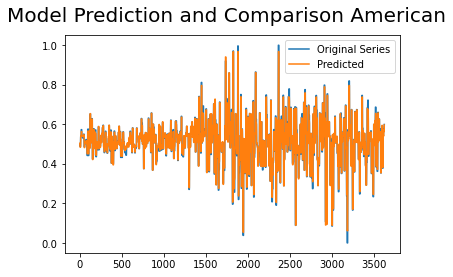

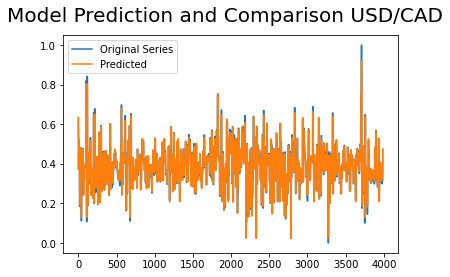

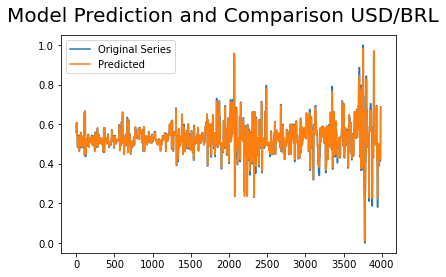


American Model Prediction Errors
  Error     Value
0  MAPE       inf
1    ME -0.000264
2   MAE  0.019414
3   MPE       inf
4  RMSE  0.048165

USD/CAD Model Prediction Errors
  Error     Value
0  MAPE       inf
1    ME  0.000039
2   MAE  0.020404
3   MPE       inf
4  RMSE  0.047254

USD/BRL Model Prediction Errors
  Error     Value
0  MAPE       inf
1    ME -0.000044
2   MAE  0.014247
3   MPE       inf
4  RMSE  0.035943


C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((predicted - actual)/actual)   # MPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((predicted - actual)/actual)   # MPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99

In [10]:
american_predicted = clf_American.predict(american_X_train)
USD_CAD_predicted = clf_USD_CAD.predict(USD_CAD_X_train)
USD_BRL_predicted = clf_USD_BRL.predict(USD_BRL_X_train)

plot_2_series(real=american_y_train,
            model=american_predicted,
            title='Model Prediction and Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_train,
            model=USD_CAD_predicted,
            title='Model Prediction and Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_train,
            model=USD_BRL_predicted,
            title='Model Prediction and Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors")
print(errors(american_y_train,american_predicted))
print("\nUSD/CAD Model Prediction Errors")
print(errors(USD_CAD_y_train,USD_CAD_predicted))
print("\nUSD/BRL Model Prediction Errors")
print(errors(USD_BRL_y_train,USD_BRL_predicted))

## 1 step ahead Forecast Comparison

In here we are forecasting only one step ahead, even though it may seem that the forecast horizon is 12.

The horizon is just 1 because in the X_test, each row has the past 12 values, incluidng the one that is "in the future". We are, here, checking how the model is able to forecast the next time step knowing the past 12. In a later section the 12-step forecast is implemented.

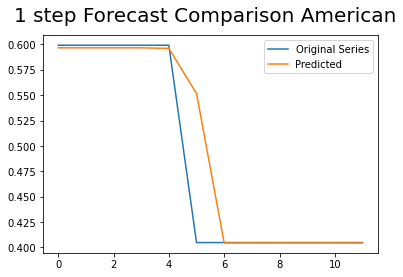

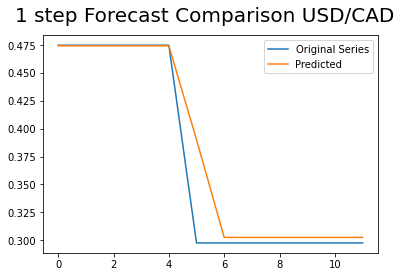

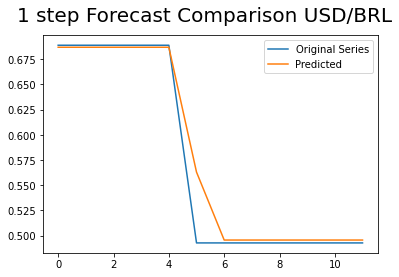


American 1 step Forecast Errors
  Error     Value
0  MAPE  0.032545
1    ME  0.010962
2   MAE  0.013530
3   MPE  0.027974
4  RMSE  0.042456

USD/CAD 1 step Forecast Errors
  Error     Value
0  MAPE  0.034647
1    ME  0.009972
2   MAE  0.010389
3   MPE  0.033769
4  RMSE  0.026937

USD/BRL 1 step Forecast Errors
  Error     Value
0  MAPE  0.015978
1    ME  0.006451
2   MAE  0.008110
3   MPE  0.013570
4  RMSE  0.020419


In [11]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)

plot_2_series(real=american_y_test,
            model=american_forecast,
            title='1 step Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='1 step Forecast Comparison USD/CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='1 step Forecast Comparison USD/BRL',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican 1 step Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 1 step Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 1 step Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

## 12 step ahead Forecast Comparison

Now, instead of forecasting only the next immediate value for the series, we are implement a multi step (h) forecast.

How the funciton works is explained in the cell where it is implemented, in the beggining of this notebook, so here we present just a brief explanaiton of the idea behind the milti step forecast.

The basic idea is to, first, forecast only the next value of the series. However, when this value is predicted, we feed the serie with it, shifting every entry in the series to the left and adding the new value in the last entry, making the predicted value the most recent one in the time series. Iterating through this process will make the next forecasting respond to the previous one. That is how we accomplish multi step forecasting.

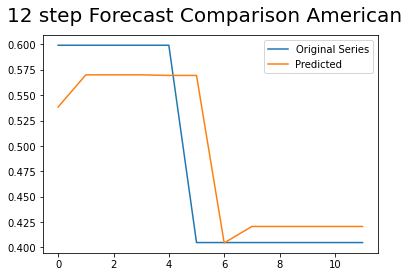

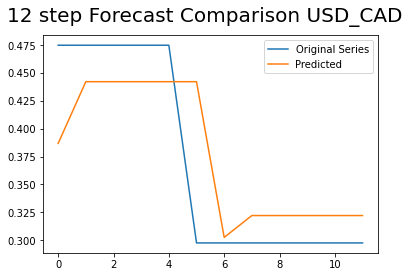

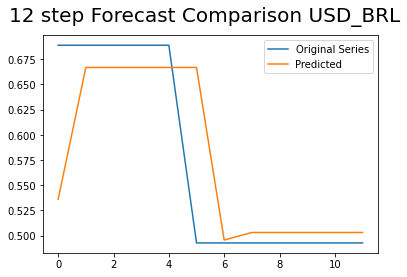


American 12 step Forecast Errors
  Error     Value
0  MAPE  0.075098
1    ME  0.005462
2   MAE  0.035210
3   MPE  0.025405
4  RMSE  0.054426

USD/CAD 12 step Forecast Errors
  Error     Value
0  MAPE  0.114508
1    ME  0.004456
2   MAE  0.040871
3   MPE  0.037792
4  RMSE  0.054682

USD/BRL 12 step Forecast Errors
  Error     Value
0  MAPE  0.067838
1    ME -0.001012
2   MAE  0.039146
3   MPE  0.009547
4  RMSE  0.068409


In [12]:
horizon = 12 #how many steps we want to forecast -> the same size of our test set

american_forecast = h_step_forecast(clf_American,american_X_test,horizon)
USD_CAD_forecast = h_step_forecast(clf_USD_CAD,USD_CAD_X_test,horizon)
USD_BRL_forecast = h_step_forecast(clf_USD_BRL,USD_BRL_X_test,horizon)

plot_2_series(real=american_y_test,
            model=american_forecast,
            title='12 step Forecast Comparison American',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='12 step Forecast Comparison USD_CAD',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='12 step Forecast Comparison USD_BRL',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican 12 step Forecast Errors")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 12 step Forecast Errors")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 12 step Forecast Errors")
print(errors(USD_BRL_y_test,USD_BRL_forecast))



---------------------------------------------------------------------------------------------------------------------------------

## Non-Stationary Series

We must make an observation: a reason for implementing the models on differentiated series was, not only to compare with ARIMA, but also because it is more useful to model *stock return* series than stock prices themselves. By differentiating the series we get, precisely, the returns.

With that being said, the goal to model with non-stationary series is to study each model capacity to forecast that type of time series. One could say that the goal is to check if those models accpet more general forms of time series than ARIMA and GARCH models that are implemented only in stationary ones. 

The process from now on will be **exactly** the same, so comments won't be made unless necessary, since everything is already explained in the previous part.

## Training and Test Sets

In [13]:
# #normalizing the series
USD_CAD_serie = normalize(USD_CAD_serie)
USD_BRL_serie = normalize(USD_BRL_serie)
AmericanAirlines_serie = normalize(AmericanAirlines_serie)

split = 12 #number of entries for test
lags = 12 #number of past values that will be used to train the model

train_American, test_American = moving_window(AmericanAirlines_serie,lags,split)
train_USD_CAD, test_USD_CAD = moving_window(USD_CAD_serie,lags,split)
train_USD_BRL, test_USD_BRL = moving_window(USD_BRL_serie,lags,split)

#Let's take a look into the test series
print(test_American.head())

#Let's just take a look into the dataframe.
train_American.head()

    y(t-12)   y(t-11)   y(t-10)    y(t-9)    y(t-8)    y(t-7)    y(t-6)  \
0  0.445311  0.446597  0.447884  0.449171  0.451396  0.453621  0.455847   
1  0.446597  0.447884  0.449171  0.451396  0.453621  0.455847  0.458072   
2  0.447884  0.449171  0.451396  0.453621  0.455847  0.458072  0.460297   
3  0.449171  0.451396  0.453621  0.455847  0.458072  0.460297  0.462522   
4  0.451396  0.453621  0.455847  0.458072  0.460297  0.462522  0.464747   

     y(t-5)    y(t-4)    y(t-3)    y(t-2)    y(t-1)      y(t)    y(t+1)  
0  0.458072  0.460297  0.462522  0.464747  0.467750  0.470752  0.473755  
1  0.460297  0.462522  0.464747  0.467750  0.470752  0.473755  0.476757  
2  0.462522  0.464747  0.467750  0.470752  0.473755  0.476757  0.479760  
3  0.464747  0.467750  0.470752  0.473755  0.476757  0.479760  0.482763  
4  0.467750  0.470752  0.473755  0.476757  0.479760  0.482763  0.485765  


,y(t-12),y(t-11),y(t-10),y(t-9),y(t-8),y(t-7),y(t-6),y(t-5),y(t-4),y(t-3),y(t-2),y(t-1),y(t),y(t+1)
0,0.022019,0.022907,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255
1,0.022907,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925
2,0.023794,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114
3,0.024682,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114,0.024302
4,0.025570,0.026458,0.027346,0.028234,0.027904,0.027574,0.027244,0.026915,0.026585,0.026255,0.025925,0.025114,0.024302,0.023490


### Splitting into X and y

In [14]:
american_X_train, american_y_train, american_X_test, american_y_test = train_test(train_American, test_American) 
USD_CAD_X_train, USD_CAD_y_train, USD_CAD_X_test, USD_CAD_y_test = train_test(train_USD_CAD, test_USD_CAD) 
USD_BRL_X_train, USD_BRL_y_train, USD_BRL_X_test, USD_BRL_y_test = train_test(train_USD_BRL, test_USD_BRL) 

## Implementing Random Forests with Hyperparemeter Search

In [15]:
#Hyperparameters
max_depth = [5,10,15,20,50,100]
n_estimators = [10,20,50,100,200]

In [17]:
clf = sklearn.ensemble.RandomForestRegressor(random_state=0)
param_grid = {'max_depth':max_depth,'n_estimators':n_estimators}

clf_grid_American = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(american_X_train,american_y_train)
clf_grid_USD_CAD = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_CAD_X_train,USD_CAD_y_train)
clf_grid_USD_BRL = sklearn.model_selection.GridSearchCV(clf, param_grid).fit(USD_BRL_X_train,USD_BRL_y_train)


In [18]:
print('Best Hyperparameters American' ,clf_grid_American.best_params_)
print('Training Accuracy American',clf_grid_American.score(american_X_train,american_y_train))

print('\nBest Hyperparameters USD/CAD' ,clf_grid_USD_CAD.best_params_)
print('Training Accuracy USD/CAD',clf_grid_USD_CAD.score(USD_CAD_X_train,USD_CAD_y_train))

print('\nBest Hyperparameters USD/BRL' ,clf_grid_USD_BRL.best_params_)
print('Training Accuracy USD/BRL',clf_grid_USD_BRL.score(USD_BRL_X_train,USD_BRL_y_train))

Best Hyperparameters American {'max_depth': 50, 'n_estimators': 100}
Training Accuracy American 0.999979511686754

Best Hyperparameters USD/CAD {'max_depth': 10, 'n_estimators': 20}
Training Accuracy USD/CAD 0.9999685757898217

Best Hyperparameters USD/BRL {'max_depth': 15, 'n_estimators': 20}
Training Accuracy USD/BRL 0.9999873114173539


### Training the Random Forests with the best hyperparameters

In [19]:
clf_American = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=50,
                                                    n_estimators=100).fit(american_X_train,american_y_train)


clf_USD_CAD = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=10,
                                                    n_estimators=20).fit(USD_CAD_X_train,USD_CAD_y_train)

clf_USD_BRL = sklearn.ensemble.RandomForestRegressor(random_state=0,
                                                    max_depth=15,
                                                    n_estimators=20).fit(USD_BRL_X_train,USD_BRL_y_train)                           

## Model Training comparison

Here we will use each estimator to view and compare the prediction of the estimator with the original values for training

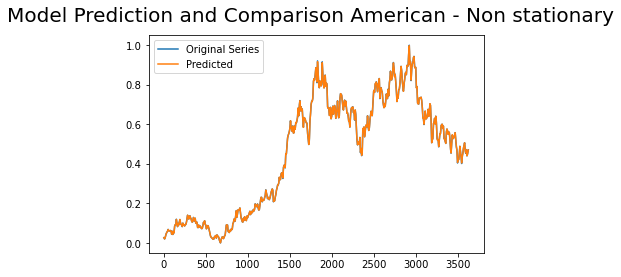

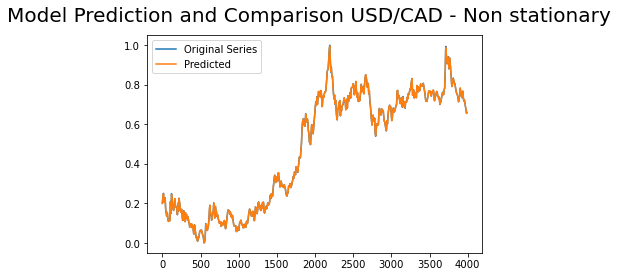

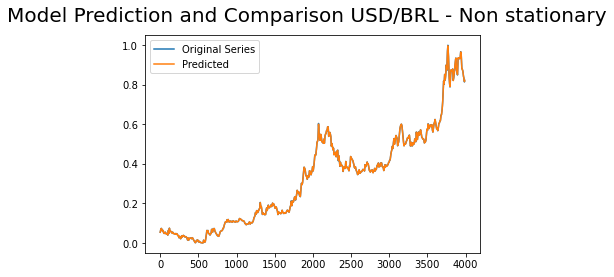


American Model Prediction Errors - Non stationary
  Error     Value
0  MAPE       inf
1    ME  0.000002
2   MAE  0.000834
3   MPE       inf
4  RMSE  0.001299

USD/CAD Model Prediction Errors - Non stationary
  Error     Value
0  MAPE       inf
1    ME -0.000023
2   MAE  0.001177
3   MPE       inf
4  RMSE  0.001638

USD/BRL Model Prediction Errors - Non stationary
  Error     Value
0  MAPE       inf
1    ME  0.000004
2   MAE  0.000514
3   MPE       inf
4  RMSE  0.000873


C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((predicted - actual)/actual)   # MPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99: RuntimeWarning: divide by zero encountered in true_divide
  mpe = np.mean((predicted - actual)/actual)   # MPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:96: RuntimeWarning: divide by zero encountered in true_divide
  mape = np.mean(np.abs(predicted - actual)/np.abs(actual))  # MAPE
C:\Users\matno\AppData\Local\Temp/ipykernel_4616/3336184938.py:99

In [20]:
american_predicted = clf_American.predict(american_X_train)
USD_CAD_predicted = clf_USD_CAD.predict(USD_CAD_X_train)
USD_BRL_predicted = clf_USD_BRL.predict(USD_BRL_X_train)

plot_2_series(real=american_y_train,
            model=american_predicted,
            title='Model Prediction and Comparison American - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_train,
            model=USD_CAD_predicted,
            title='Model Prediction and Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_train,
            model=USD_BRL_predicted,
            title='Model Prediction and Comparison USD/BRL - Non stationary',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican Model Prediction Errors - Non stationary")
print(errors(american_y_train,american_predicted))
print("\nUSD/CAD Model Prediction Errors - Non stationary")
print(errors(USD_CAD_y_train,USD_CAD_predicted))
print("\nUSD/BRL Model Prediction Errors - Non stationary")
print(errors(USD_BRL_y_train,USD_BRL_predicted))

## 1 step ahead Forecast Comparison

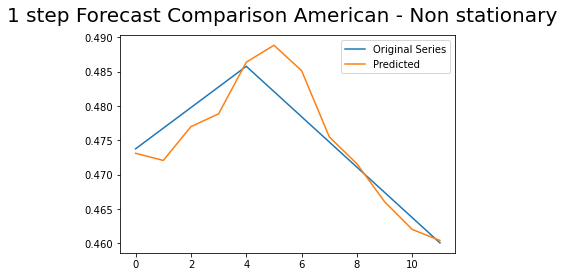

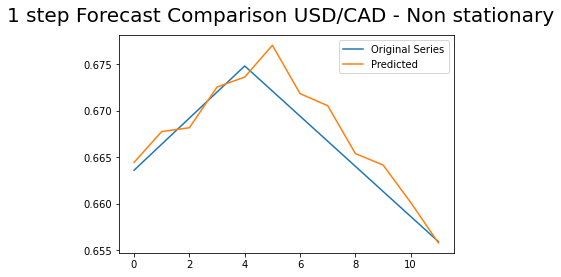

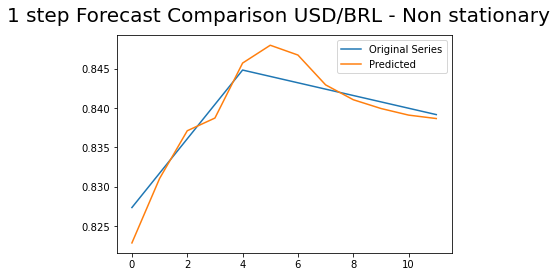


American 1 step Forecast Errors - Non stationary
  Error     Value
0  MAPE  0.005361
1    ME  0.000044
2   MAE  0.002562
3   MPE  0.000075
4  RMSE  0.003438

USD/CAD 1 step Forecast Errors - Non stationary
  Error     Value
0  MAPE  0.002751
1    ME  0.001440
2   MAE  0.001836
3   MPE  0.002162
4  RMSE  0.002282

USD/BRL 1 step Forecast Errors - Non stationary
  Error     Value
0  MAPE  0.001946
1    ME  0.000023
2   MAE  0.001631
3   MPE  0.000017
4  RMSE  0.002157


In [21]:
american_forecast = clf_American.predict(american_X_test)
USD_CAD_forecast = clf_USD_CAD.predict(USD_CAD_X_test)
USD_BRL_forecast = clf_USD_BRL.predict(USD_BRL_X_test)

plot_2_series(real=american_y_test,
            model=american_forecast,
            title='1 step Forecast Comparison American - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='1 step Forecast Comparison USD/CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='1 step Forecast Comparison USD/BRL - Non stationary',
            xlabel='Years',
            ylabel='Value')

            
print("\nAmerican 1 step Forecast Errors - Non stationary")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 1 step Forecast Errors - Non stationary")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 1 step Forecast Errors - Non stationary")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

## 12 step ahead Forecast Comparison

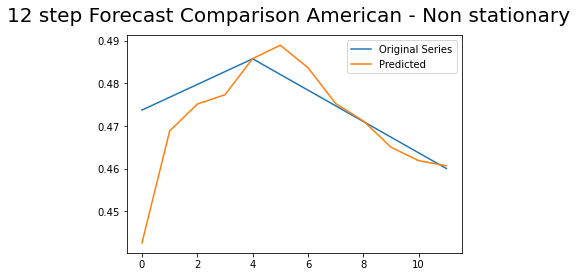

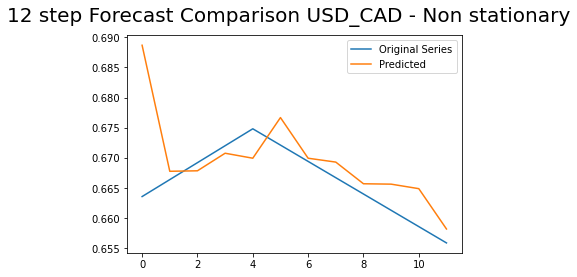

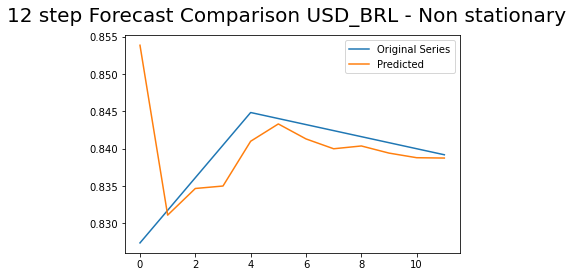


American 12 step Forecast Errors - Non-stationary
  Error     Value
0  MAPE  0.011687
1    ME -0.003315
2   MAE  0.005561
3   MPE -0.007000
4  RMSE  0.009861

USD/CAD 12 step Forecast Error - Non-stationarys
  Error     Value
0  MAPE  0.007050
1    ME  0.003442
2   MAE  0.004687
3   MPE  0.005202
4  RMSE  0.007919

USD/BRL 12 step Forecast Errors - Non-stationary
  Error     Value
0  MAPE  0.004720
1    ME  0.000475
2   MAE  0.003934
3   MPE  0.000609
4  RMSE  0.007971


In [22]:
horizon = 12 #how many steps we want to forecast -> the same size of our test set

american_forecast = h_step_forecast(clf_American,american_X_test,horizon)
USD_CAD_forecast = h_step_forecast(clf_USD_CAD,USD_CAD_X_test,horizon)
USD_BRL_forecast = h_step_forecast(clf_USD_BRL,USD_BRL_X_test,horizon)

plot_2_series(real=american_y_test,
            model=american_forecast,
            title='12 step Forecast Comparison American - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_CAD_y_test,
            model=USD_CAD_forecast,
            title='12 step Forecast Comparison USD_CAD - Non stationary',
            xlabel='Years',
            ylabel='Value')

plot_2_series(real=USD_BRL_y_test,
            model=USD_BRL_forecast,
            title='12 step Forecast Comparison USD_BRL - Non stationary',
            xlabel='Years',
            ylabel='Value')


print("\nAmerican 12 step Forecast Errors - Non-stationary")
print(errors(american_y_test,american_forecast))
print("\nUSD/CAD 12 step Forecast Error - Non-stationarys")
print(errors(USD_CAD_y_test,USD_CAD_forecast))
print("\nUSD/BRL 12 step Forecast Errors - Non-stationary")
print(errors(USD_BRL_y_test,USD_BRL_forecast))

